In [66]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [67]:
# GLOBAL VARS
dataset_size = None
batch_size = 32
log_iter = 2
global_emotion_label = 'emo8'

In [68]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [69]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [70]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [71]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [72]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [73]:
len(df)

25867

In [74]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [75]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [76]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [77]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [78]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [79]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [80]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [81]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig

emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [82]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [83]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [84]:
get_category_name = lambda idx: scene_categories[idx]

In [85]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        model_output = torch.load(os.path.join(data_dir, "pretrained_logits", "faces", f"face_{sample_idx}_{face_rank}.pt")).to(DEVICE).unsqueeze(0)
        probs_output = torch.softmax(model_output, dim=1)
        probs = probs_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_logits = torch.load(os.path.join(data_dir, "pretrained_logits", "scenes", f"scene_{sample_idx}.pt")).to(DEVICE)
    scene_probs = torch.softmax(scene_logits, dim=0)
   

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(scene_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {get_category_name(idx)}: {prob:.4f}")
    print("")


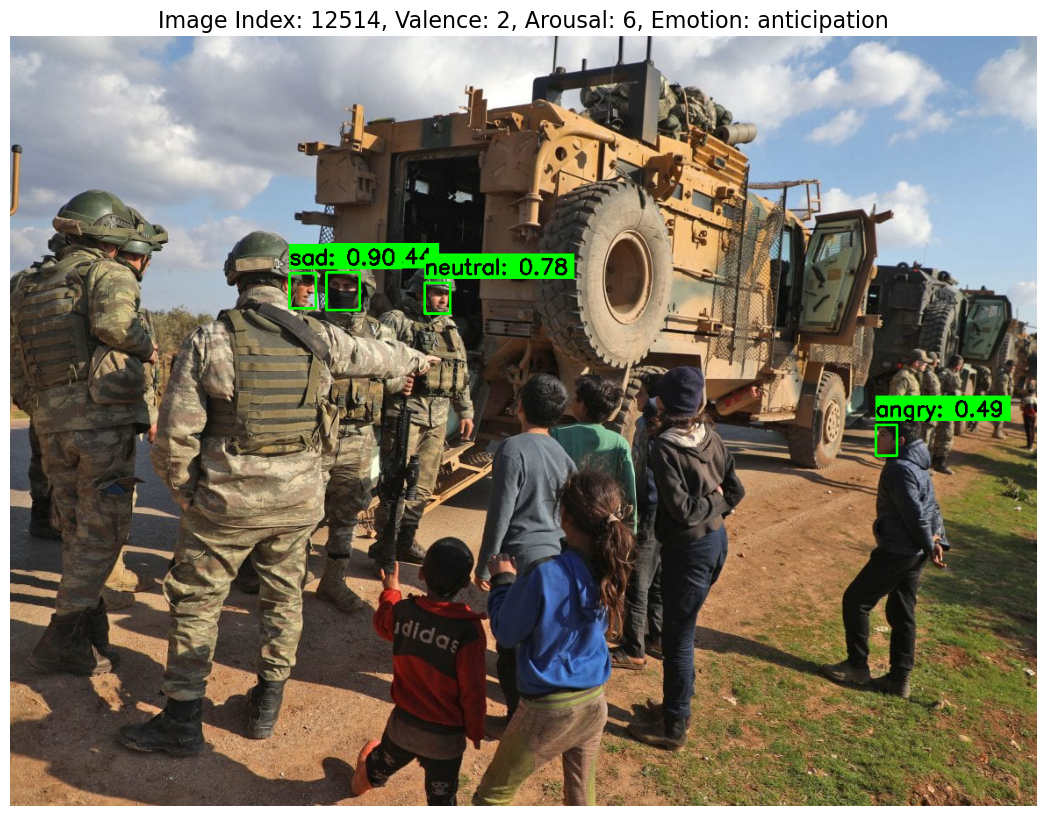

Base model (365 categories):
  army_base: 0.9870
  landfill: 0.0017
  slum: 0.0016



In [86]:
show_pretrained_model_predictions_on_sample(np.random.randint(len(df)))

In [87]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [88]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [89]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "scenes_5"), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        tensor = super().__getitem__(f"scene_{i}")
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

In [94]:
scene_priors_path = os.path.join(data_dir, "scene_priors.xlsx")
scene_priors = pd.read_excel(scene_priors_path, index_col=0)
scene_priors.head()

,valence,arousal,nr_samples
scene_category,,,
airfield,4.000000,3.000000,2
airplane_cabin,3.059829,3.025641,117
airport_terminal,2.952381,2.190476,42
alcove,4.000000,1.000000,1
alley,3.130435,2.608696,23


In [110]:
def remove_brackets(lst):  
    return ', '.join(lst)

In [112]:
# Create the prolog file
prolog_file_name = "model7.pl"
prolog_file_path = os.path.join(prolog_dir, prolog_file_name)
with open(prolog_file_path, "w") as f:

    f.write("nn(face_model, [Face], Emotion,\n")
    f.write("   [angry, disgust, fear, happy, neutral, sad, surprise]) ::\n")
    f.write("   face_emotion(Face, Emotion).\n\n")

    f.write(f"nn(scene_model, [SceneTensor], Scene, [{remove_brackets(list(scene_priors.index))}]) ::\n")
    f.write("   scene(SceneTensor, Scene).\n\n")

    f.write(f"nn(positive_emotion_model, [FaceFeatures, SceneTensor], Emotion,\n")
    f.write("   [joy, trust, anticipation]) ::\n")
    f.write("   get_positive_emotion(FaceFeatures, SceneTensor, Emotion).\n\n")

    f.write("nn(negative_emotion_model, [FaceFeatures, SceneTensor], Emotion,\n")
    f.write("   [angry, fear, disgust]) ::\n")
    f.write("   get_negative_emotion(FaceFeatures, SceneTensor, Emotion).\n\n")


    for scene, row, in scene_priors.iterrows():
        if not (np.isnan(row['valence']) or np.isnan(row['arousal'])):
            f.write(f"scene_prior({scene}, {round(row['valence'], 2)}, {round(row['arousal'], 2)}).\n")
        else:
            # allocate random values for valence and arousal between 0 and 6
            valence = round(random.uniform(0, 6), 2)
            arousal = round(random.uniform(0, 6), 2)
            f.write(f"scene_prior({scene}, {valence}, {arousal}).\n")

    # Next step model these with gaussian distribution so we don't always have fixed values, maybe also for the scene priors
    f.write("\n")
    f.write("face_prior(angry, 1.2, 5.1).\n")
    f.write("face_prior(disgust, 0.9, 3.1).\n")
    f.write("face_prior(fear, 0.6, 5.4).\n")
    f.write("face_prior(happy, 5.4, 4.8).\n")
    f.write("face_prior(neutral, 3.0, 2.4).\n")
    f.write("face_prior(sad, 0.9, 1.5).\n")
    f.write("face_prior(surprise, 3.3, 5.4).\n")
    f.write("\n")

    f.write("small_diff(F, S)  :- abs(F - S) =< 1.\n")
    f.write("medium_diff(F, S) :- D is abs(F - S), D > 1, D =< 3.\n")
    f.write("large_diff(F, S)  :- abs(F - S) > 3.\n")

    f.write("\n")
    f.write(f"t(_) :: use_face_small_val(F,S) ; t(_) :: use_scene_small_val(F,S).\n")
    f.write(f"t(_) :: use_face_small_aro(F,S) ; t(_) :: use_scene_small_aro(F,S).\n")
    f.write(f"t(_) :: use_face_big_val(F,S) ; t(_) :: use_scene_big_val(F,S).\n")
    f.write(f"t(_) :: use_face_big_aro(F,S) ; t(_) :: use_scene_big_aro(F,S).\n")
    f.write("\n")

    f.write("combine_val(FV, SV, FV) :-\n")
    f.write("    small_diff(FV, SV), \n")
    f.write("    use_face_small_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(FV, SV, SV) :-\n")
    f.write("    small_diff(FV, SV), \n")
    f.write("    use_scene_small_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(F, S, M) :-\n")
    f.write("    medium_diff(F, S), \n")
    f.write("    M is (2*F + S) / 3. \n")
    f.write("\n")
    f.write("combine_val(FV, SV, FV) :-\n")
    f.write("    large_diff(FV, SV), \n")
    f.write("    use_face_big_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(FV, SV, SV) :-\n")
    f.write("    large_diff(FV, SV), \n")
    f.write("    use_scene_big_val(FV, SV). \n")
    f.write("\n")

    f.write("combine_aro(FA, SA, FA) :-\n")
    f.write("    small_diff(FA, SA), \n")
    f.write("    use_face_small_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, SA) :-\n")
    f.write("    small_diff(FA, SA), \n")
    f.write("    use_scene_small_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(F, S, M) :-\n")
    f.write("    medium_diff(F, S), \n")
    f.write("    M is (2*F + S) / 3. \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, FA) :-\n")
    f.write("    large_diff(FA, SA), \n")
    f.write("    use_face_big_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, SA) :-\n")
    f.write("    large_diff(FA, SA), \n")
    f.write("    use_scene_big_aro(FA, SA). \n")
    f.write("\n")
    
    f.write("predict_emotion(CV, CA, FaceFeatures, SceneTensor, sadness) :-\n")
    f.write("    CV < 2.5, \n")
    f.write("    CA < 3. \n")
    f.write("\n")

    f.write("predict_emotion(CV, CA, FaceFeatures, SceneTensor, Emotion) :-\n")
    f.write("    CV < 2.5, \n")
    f.write("    CA >= 3, \n")
    # Predict between anger, fear and disgust using MLP
    f.write("    get_negative_emotion(FaceFeatures, SceneTensor, Emotion). \n")
    f.write("\n")

    f.write("predict_emotion(CV, CA, FaceFeatures, SceneTensor, surprise) :-\n")
    f.write("    CV > 2.5, \n")
    f.write("    CA >= 3.5. \n")

    f.write("\n")
    f.write("predict_emotion(CV, CA, FaceFeatures, SceneTensor, Emotion) :-\n")
    f.write("    CV > 2.5, \n")
    f.write("    CA >= 4, \n")
    # Predict between joy, trust and anticipation using MLP
    f.write("    get_positive_emotion(FaceFeatures, SceneTensor, Emotion). \n")
    f.write("\n")

    f.write("predict_emotion(CV, CA, FaceFeatures, SceneTensor, trust) :-\n")
    f.write("    CV > 2.5, \n")
    f.write("    CA < 4. \n")

    f.write("\n")
    f.write("final_emotion(FaceFeatures, SceneTensor, Emotion) :-\n")
    f.write("    face_emotion(FaceFeatures, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(SceneTensor, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA),\n")
    f.write("    combine_val(FV, SV, CV),\n")
    f.write("    combine_aro(FA, SA, CA),\n")
    f.write("    predict_emotion(CV, CA, FaceFeatures, SceneTensor, Emotion). \n")
    f.write("\n")

print("Prolog file written to:", prolog_file_path)

Prolog file written to: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog\model7.pl


In [ ]:
def save_pretrained_logits_separately(indices, output_dir):
    """
    Save pre-computed logits from pretrained models to separate files.
    
    Args:
        indices: list of sample indices to process
        output_dir: base directory to save the logits
    """
    # Create output directories
    scene_dir = os.path.join(output_dir, "scenes")
    faces_dir = os.path.join(output_dir, "faces")
    os.makedirs(scene_dir, exist_ok=True)
    os.makedirs(faces_dir, exist_ok=True)
    
    # Set models to eval mode
    face_model_base.eval()
    scene_model_base.eval()
    
    for img_idx in tqdm(indices, desc="Saving pretrained logits"):
        # ----- PROCESS SCENE -----
        scene_img = scenes_dataset[(img_idx,)].to(DEVICE).unsqueeze(0)  # (1, C, H, W)
        
        with torch.no_grad():
            scene_logits = scene_model_base(scene_img).squeeze(0)  # (365,)
        
        # Save scene logits
        scene_file = os.path.join(scene_dir, f"scene_{img_idx}.pt")
        torch.save(scene_logits.cpu(), scene_file)
        
        # ----- PROCESS FACES -----
        face_rows = df_boxes[df_boxes['index'] == img_idx].sort_values('face_rank')
        
        for _, row in face_rows.iterrows():
            face_rank = int(row['face_rank'])
            face_tensor = faces_dataset[(img_idx, face_rank)]
            
            with torch.no_grad():
                face_tensor = face_tensor.to(DEVICE).unsqueeze(0)  # (1, C, H, W)
                outputs = face_model_base(face_tensor)  # Returns ImageClassifierOutput
                face_logits = outputs.logits.squeeze(0)  # (7,)
            
            # Save face logits
            face_file = os.path.join(faces_dir, f"face_{img_idx}_{face_rank}.pt")
            torch.save(face_logits.cpu(), face_file)
    
    print(f"\nLogits saved to:")
    print(f"  Scenes: {scene_dir}")
    print(f"  Faces: {faces_dir}")

# Usage:
save_pretrained_logits_separately(indices, output_dir=os.path.join(data_dir, "precalc_logits"))

In [ ]:
class SceneNet(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.base = pretrained_model

    def forward(self, idx):
        sc

for p in scene_model_base.parameters():
    p.requires_grad = False

scene_model = SceneNet(pretrained_model=scene_model_base).to(DEVICE)      

scene_network = Network(scene_model, "scene_model", batching=True)
scene_network.optimizer = None